# Segmentez des clients d'un site e-commerce - Simulation

Pascaline Grondein

Début : 30/05/2022

<i/> Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne. </i>

<i/> Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

<i/>Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

<i/>Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.</i>

### Table of Contents

* [I. Test sur une période](#chapter1)
* [II. Fonction](#chapter2)
* [III. Test sur plusieurs périodes](#chapter3)

In [1]:
%matplotlib inline

import pandas as pd
pd.set_option('precision', 2)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import matplotlib.cm as cm

import time
from time import process_time
from datetime import datetime  
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data.csv', index_col = 'Unnamed: 0')
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

In [3]:
date_ref = max(data['order_purchase_timestamp'])
rs = 42

In [4]:
#RFM+ features calculation function

def rfm_plus(df):
    
    #RECENSE
    recense = df[['customer_unique_id','order_purchase_timestamp']]
    recense = recense.sort_values(by = 'order_purchase_timestamp', axis = 0 , ascending = False)
    recense = recense.drop_duplicates(subset = ['customer_unique_id'])
    recense['Recense'] = (date_ref - recense['order_purchase_timestamp']).dt.days
    recense = recense.set_index('customer_unique_id').drop('order_purchase_timestamp', axis = 1)
    #display(recense)

    #FREQUENCE
    freq = pd.DataFrame(df['customer_unique_id'].value_counts())
    freq = freq.rename(columns = {'customer_unique_id' : 'Frequence' })
    #display(freq)

    #MONTANT
    montant = df[['customer_unique_id', 'payment_value']]
    montant = montant.groupby(by = ['customer_unique_id'], axis = 0, as_index = False).sum()
    montant = montant.rename(columns = {'payment_value' : 'Payment'}).set_index('customer_unique_id')
    #display(payment)

    #Review score + Average nb of items
    item_review = df.groupby(by = ['customer_unique_id'], axis = 0, as_index = False).mean()
    item_review = item_review.set_index('customer_unique_id')
    item_review = item_review.rename(columns = { 'order_item_id' : 'Average_nb_items', 
                                                'review_score' : 'Review_score'}).drop('payment_value', axis = 1)
    #display(item_review)

    df_RFM_plus = pd.concat([recense, freq, montant, item_review], axis = 1)
    return df_RFM_plus

# <a class="anchor" id="chapter2">I. Test sur une période</a>

In [5]:
n_clust = 5
date_ref = max(data['order_purchase_timestamp'])
kmeans_kwargs = {
    "init" : "random",
    "n_clusters" : n_clust,
    "n_init" : 10,
    "max_iter" : 300,
    "random_state" : rs,
    }

In [6]:
#Define first, last date, and time difference
ti = data['order_purchase_timestamp'].min()
tf = data['order_purchase_timestamp'].max()
dt = tf - ti

#Define period in days
nj = 30

#Nb of periods
n_p = int(dt/timedelta(days = nj))

In [7]:
#Define time mark and masks
p = 1
d0 = ti + timedelta(days = (nj*p))
d1 = ti + timedelta(days = (nj*(p+1)))

mask0 = ((data['order_purchase_timestamp'] >= ti) & (data['order_purchase_timestamp'] < d0))
mask1 = ((data['order_purchase_timestamp'] >= ti) & (data['order_purchase_timestamp']< d1))

In [8]:
#Select F0
F0 = data.loc[mask0]

In [9]:
#RFM+ FOR F0

F0_RFM = rfm_plus(F0)
#F0_RFM

In [10]:
#MinMaxScaler for F0
scaler = MinMaxScaler()
F0_RFM_MinMax = pd.DataFrame(data = scaler.fit_transform(F0_RFM), 
                             columns = F0_RFM.columns, index = F0_RFM.index)
#F0_RFM_MinMax

In [11]:
#Select F1
F1 = data.loc[mask1]

In [12]:
#RFM+ FOR F1

F1_RFM = rfm_plus(F1)
#F1_RFM 

In [13]:
#MinMaxScaler for F1
F1_RFM_MinMax = pd.DataFrame(data = scaler.transform(F1_RFM), 
                             columns = F1_RFM.columns, index = F1_RFM.index)
#F1_RFM_MinMax

In [14]:
#Kmeans on F0
M0 = KMeans(**kmeans_kwargs).fit(F0_RFM_MinMax)

#Predict on F1
C1_pred = M0.predict(F1_RFM_MinMax)

#Kmeans on F1
M1 = KMeans(**kmeans_kwargs).fit(F1_RFM_MinMax)
C1 = M1.predict(F1_RFM_MinMax)

#ARI calculation
ari = adjusted_rand_score(C1, C1_pred)
display(ari)

0.5775651376528473

# <a class="anchor" id="chapter2">II. Fonction</a>

In [23]:
def test_period(df, nj, n_clust):
    #nj : period in days
    #n_clust : number of clusters
    
    
    print('----- Period = ', k,' days -----')
    
    #PARAMETERS FOR KMEANS
    kmeans_kwargs = {
        "init" : "random",
        "n_clusters" : n_clust,
        "n_init" : 10,
        "max_iter" : 300,
        "random_state" : rs,
        }
    

    #Define first, last date, and time difference
    ti = df['order_purchase_timestamp'].min()
    tf = df['order_purchase_timestamp'].max()
    dt = tf - ti

    #Nb of periods
    n_p = int(dt/timedelta(days = nj))
    
    
    #Creation of df for ARS
    ARI = pd.DataFrame(columns = ['Period', 'Adjusted Rand Index'])
    
    #ARS CALCULATION
    for p in range(1, n_p):
            
        #Define time marks and masks
        d0 = ti + timedelta(days = (nj*p))
        d1 = ti + timedelta(days = nj*(p+1))

        mask0 = ((data['order_purchase_timestamp'] >= ti) & (data['order_purchase_timestamp'] <= d0))
        mask1 = ((data['order_purchase_timestamp'] >= ti) & (data['order_purchase_timestamp'] <= d1))
    
        #Select F0 + RFM calculation
        F0 = df.loc[mask0]
        a = F0.shape[0]
    
        if a > n_clust :
            
            F0_RFM = rfm_plus(F0)
    
            #Select F1 + RFM calculation
            F1 = df.loc[mask1]
            b = F1.shape[0]
            
            if b > n_clust:
            
                F1_RFM = rfm_plus(F1)
    
                #MinMaxScaler on F0 & F1
                scaler = MinMaxScaler()
                F0_RFM_MinMax = pd.DataFrame(data = scaler.fit_transform(F0_RFM), 
                                             columns = F0_RFM.columns, index = F0_RFM.index)
        
                F1_RFM_MinMax = pd.DataFrame(data = scaler.transform(F1_RFM), 
                                             columns = F1_RFM.columns, index = F1_RFM.index)
    
        
                #KMEANS on F0
                M0 = KMeans(**kmeans_kwargs).fit(F0_RFM_MinMax)
                                                                                                                                                                
                #Prediction C1
                C1_pred = M0.predict(F1_RFM_MinMax)
    
                #KMEANS on F1
                M1 = KMeans(**kmeans_kwargs).fit(F1_RFM_MinMax) 
                                                                                   
                #True values C1 
                C1 = M1.predict(F1_RFM_MinMax)
                                                                                   
                #ARI calculation
                ari = adjusted_rand_score(C1, C1_pred)                
                ARI = ARI.append({'Period' : p, 'Adjusted Rand Index' : ari}, ignore_index = True)
    
    print(' ')                

    mean_ari = ARI['Adjusted Rand Index'].mean()
    
    plt.figure(figsize = (10, 8))
    plt.plot(ARI['Period'], ARI['Adjusted Rand Index'], marker='o')
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylim(0, 1.1)
    plt.xlim(0, n_p)
    plt.xlabel("p", fontsize = 25)
    plt.ylabel("ARI", fontsize = 25)
    plt.axhline(y = 0.8, color = 'r', linestyle = ':', label = 'Threshold')
    plt.axhline(y = mean_ari, color = 'b', linestyle = '--', label ='Mean ARI' )
    plt.legend()
        
    plt.title('Adjusted Rand Index for a {} days period'.format(nj), fontsize = 25)
    
    print('Mean ARI value : ', round(mean_ari, 2))
    print(' ')
    
    plt.show()
    
    print('  ')
    print('  ')
    
    return mean_ari

# <a class="anchor" id="chapter3">III. Test sur plusieurs périodes</a>

----- Period =  90  days -----
 
Mean ARI value :  0.57
 


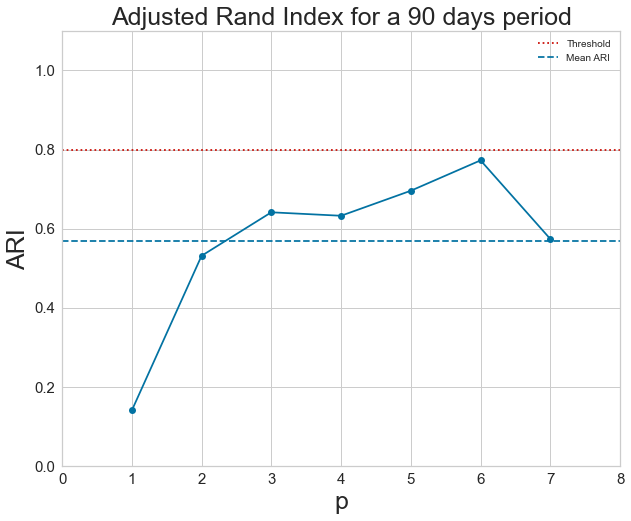

  
  
----- Period =  60  days -----
 
Mean ARI value :  0.72
 


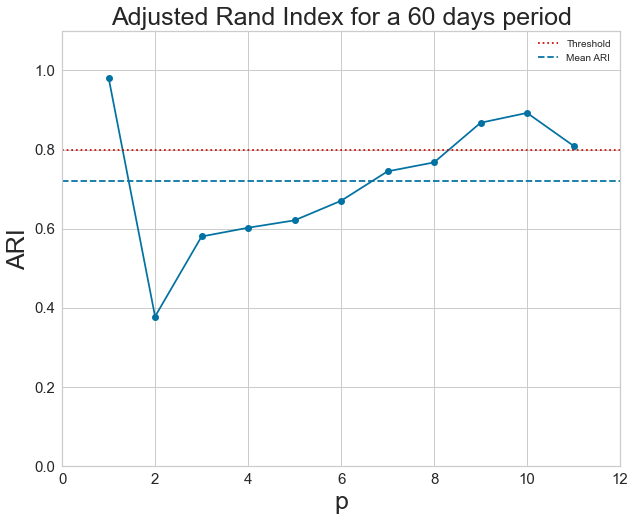

  
  
----- Period =  30  days -----
 
Mean ARI value :  0.8
 


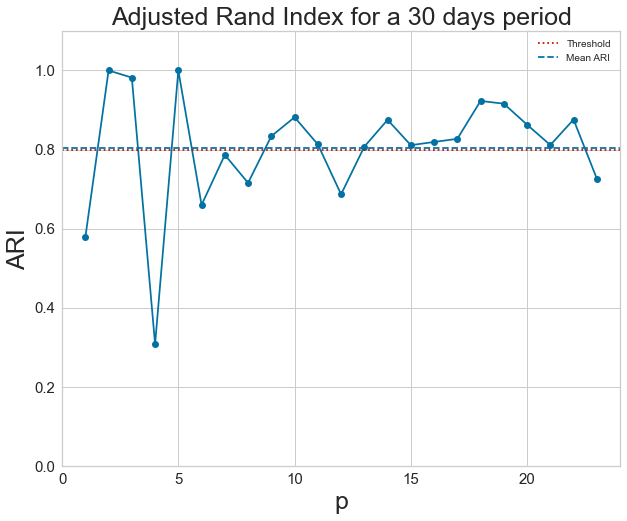

  
  
----- Period =  15  days -----
 
Mean ARI value :  0.86
 


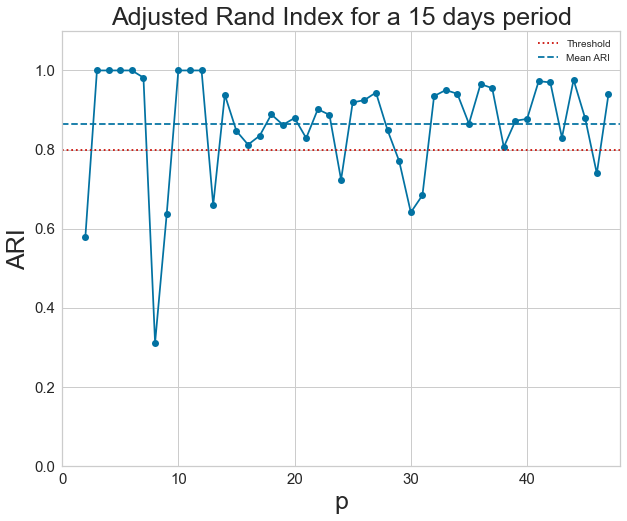

  
  
----- Period =  7  days -----
 
Mean ARI value :  0.89
 


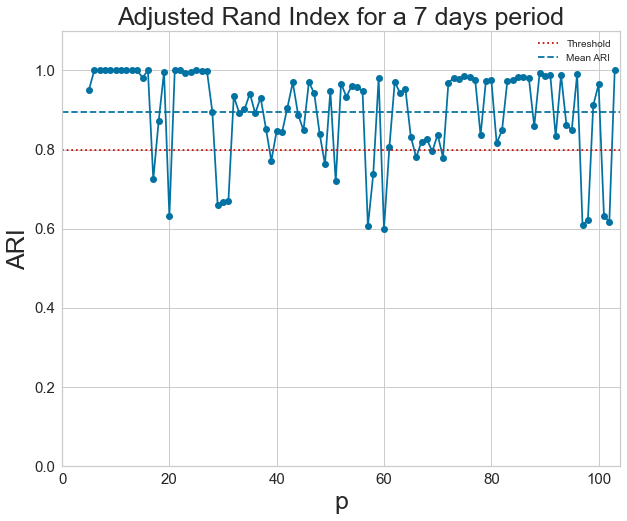

In [24]:
mean_ari = pd.DataFrame(columns = ['Period', 'Mean ARI'])

for k in [90, 60, 30, 15, 7] :
    
    m = test_period(data, nj = k , n_clust = 5)
    mean_ari = mean_ari.append({'Period' : k, 'Mean ARI' : m}, ignore_index = True)

,Period,Mean ARI
0,90.0,0.57
1,60.0,0.72
2,30.0,0.80
3,15.0,0.86
4,7.0,0.89


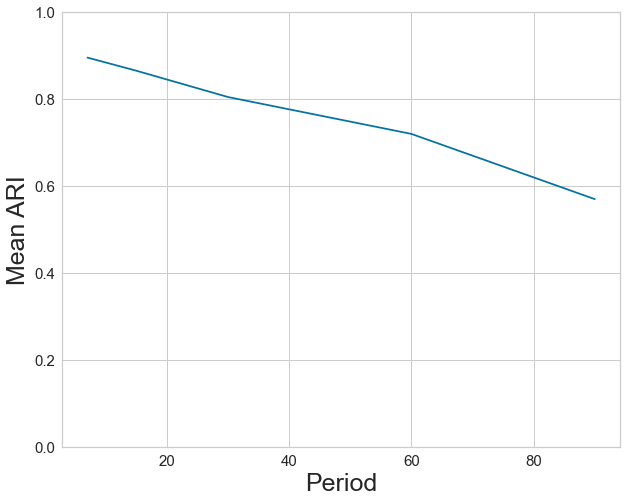

In [18]:
display(mean_ari)
plt.figure(figsize = (10, 8))
plt.plot(mean_ari['Period'], mean_ari['Mean ARI'])
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(0, 1)
plt.xlabel("Period", fontsize = 25)
plt.ylabel("Mean ARI", fontsize = 25)     
        
plt.show()

La fréquence de mise à jour permettant une stabilité du système de segmentation semble être 7 jours, avec un ARI moyen élevé.